In [2]:
# 필요한 모듈 불러오기 및 시드 고정
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, ConvLSTM2D, Conv3D, BatchNormalization, Lambda, Reshape
from tensorflow.keras.optimizers import Adadelta
from keras.callbacks import EarlyStopping, ModelCheckpoint
import numpy as np
import matplotlib.pyplot as plt
import data_preprocessing_codes.data_preprocessing as dpp
from keras import mixed_precision
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy(policy)
tf.random.set_seed(1)
np.random.seed(1)

# Data Preprocessing

#### 데이터 전처리 과정 중 문제점 해결 과정
- 기존 데이터 크기인 47,15,850,850,4를 하면 2,037,450,000개의 공간이 생김 (20억개???)
- 기존 연구 28,30,40,1 -> 33,600개
- rgba 4개의 채널까지 하더라도 134,400개임
- 100,15,40,40,4 -> 최대 천만개

#### [데이터 전처리한 주피터 노트북 파일](./data_preprocessing.ipynb)
##### [12일치 inputs 데이터](./data/data_/data_total_inputs.npy)
##### [12일치 outputs 데이터](./data/data_/data_total_outputs.npy)

In [1]:
inputs = np.load("data/data_/data_1hour_inputs.npy")
outputs = np.load("data/data_/data_1hour_outputs.npy")

NameError: name 'np' is not defined

# Modeling

In [3]:
# 자 모델 구축 들갑니다~
model = Sequential()
model.add(ConvLSTM2D(filters=40, 
                     kernel_size=(3,3), 
                     input_shape=(None,40,40,4), 
                     padding="same", 
                     return_sequences=True))
model.add(BatchNormalization())
model.add(ConvLSTM2D(filters=40, 
                     kernel_size=(3,3), 
                     padding="same", 
                     return_sequences=True))
model.add(BatchNormalization())
model.add(ConvLSTM2D(filters=40, 
                     kernel_size=(3,3), 
                     padding="same", 
                     return_sequences=True))
model.add(BatchNormalization())
model.add(ConvLSTM2D(filters=40, 
                     kernel_size=(3,3), 
                     padding="same", 
                     return_sequences=False))
model.add(Reshape((1, 40, 40, 40)))
model.add(BatchNormalization())
model.add(Conv3D(filters=4, 
                 kernel_size=(3,3,3), 
                 activation="sigmoid",
                 padding="same"))
optimizer = Adadelta(learning_rate=2.0)
model.compile(loss='binary_crossentropy',optimizer=optimizer, metrics = ['accuracy'])
callbacks_val_acc = [EarlyStopping(monitor='val_accuracy', patience=7, mode='max', restore_best_weights=True),
                     ModelCheckpoint("ClimateAI.keras", monitor='val_accuracy', save_best_only=True)]
callbacks_val_loss = [EarlyStopping(monitor='val_loss', patience=7, mode='min', restore_best_weights=True),
                      ModelCheckpoint("ClimateAI.keras", monitor='val_loss', save_best_only=True)]
callbacks = [callbacks_val_acc, callbacks_val_loss]

model.summary()

/Volumes/looparam/#1 Coding/#10 Python/AcademicFestival/AF/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv_lstm2d (ConvLSTM2D)        │ (None, None, 40, 40,   │        63,520 │
│                                 │ 40)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, None, 40, 40,   │           160 │
│ (BatchNormalization)            │ 40)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_lstm2d_1 (ConvLSTM2D)      │ (None, None, 40, 40,   │       115,360 │
│                                 │ 40)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, None, 40, 40,   │           160 │
│ (BatchNormalization)            │ 40)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_lstm2d_2 (ConvLSTM2D)      │ (None, None, 40, 40,   │       115,360 │
│                                 │ 40)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, None, 40, 40,   │           160 │
│ (BatchNormalization)            │ 40)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_lstm2d_3 (ConvLSTM2D)      │ (None, 40, 40, 40)     │       115,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 1, 40, 40, 40)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 1, 40, 40, 40)  │           160 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d (Conv3D)                 │ (None, 1, 40, 40, 4)   │         4,324 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 414,564 (1.58 MB)

 Trainable params: 414,244 (1.58 MB)

 Non-trainable params: 320 (1.25 KB)

# Train

In [112]:
model.fit(inputs, outputs, epochs=5, batch_size=1, validation_split=0.1, callbacks=callbacks)

Epoch 1/5
246/246 ━━━━━━━━━━━━━━━━━━━━ 52s 202ms/step - accuracy: 0.8396 - loss: 0.5162 - val_accuracy: 0.9971 - val_loss: 0.4926
Epoch 2/5
246/246 ━━━━━━━━━━━━━━━━━━━━ 49s 198ms/step - accuracy: 0.9970 - loss: 0.4256 - val_accuracy: 0.9971 - val_loss: 0.4497
Epoch 3/5
246/246 ━━━━━━━━━━━━━━━━━━━━ 49s 199ms/step - accuracy: 0.9970 - loss: 0.4231 - val_accuracy: 0.9971 - val_loss: 0.4259
Epoch 4/5
246/246 ━━━━━━━━━━━━━━━━━━━━ 49s 200ms/step - accuracy: 0.9970 - loss: 0.4217 - val_accuracy: 0.9971 - val_loss: 0.4257
Epoch 5/5
246/246 ━━━━━━━━━━━━━━━━━━━━ 50s 201ms/step - accuracy: 0.9970 - loss: 0.4205 - val_accuracy: 0.9971 - val_loss: 0.4233


# Predict & Check

In [4]:
loded_model = tf.keras.models.load_model("lgs-PB(3).keras")

In [166]:
test_data = inputs[:]
predict = loded_model.predict(test_data)
predict = predict.astype("float32")

18/18 ━━━━━━━━━━━━━━━━━━━━ 30s 2s/step


In [167]:
predict.shape, test_data.shape

((564, 1, 40, 40, 4), (564, 14, 40, 40, 4))

In [176]:
def show_result(select_time):
    plt.figure(figsize=(30, 15))

    for i in range(14):
        plt.subplot(3, 7, i+1)
        plt.imshow(test_data[select_time, i, :, :, :])
        plt.xlabel(f"frame_{i+1}")

    plt.subplot(3, 7, 15)
    plt.imshow(predict[select_time, 0, :, :, :])
    plt.xlabel("prediction (frame_12)")
    plt.subplot(3, 7, 16)
    plt.imshow(outputs[select_time,0,:,:,:])
    plt.xlabel("Real data (frame_12)")
    plt.show()

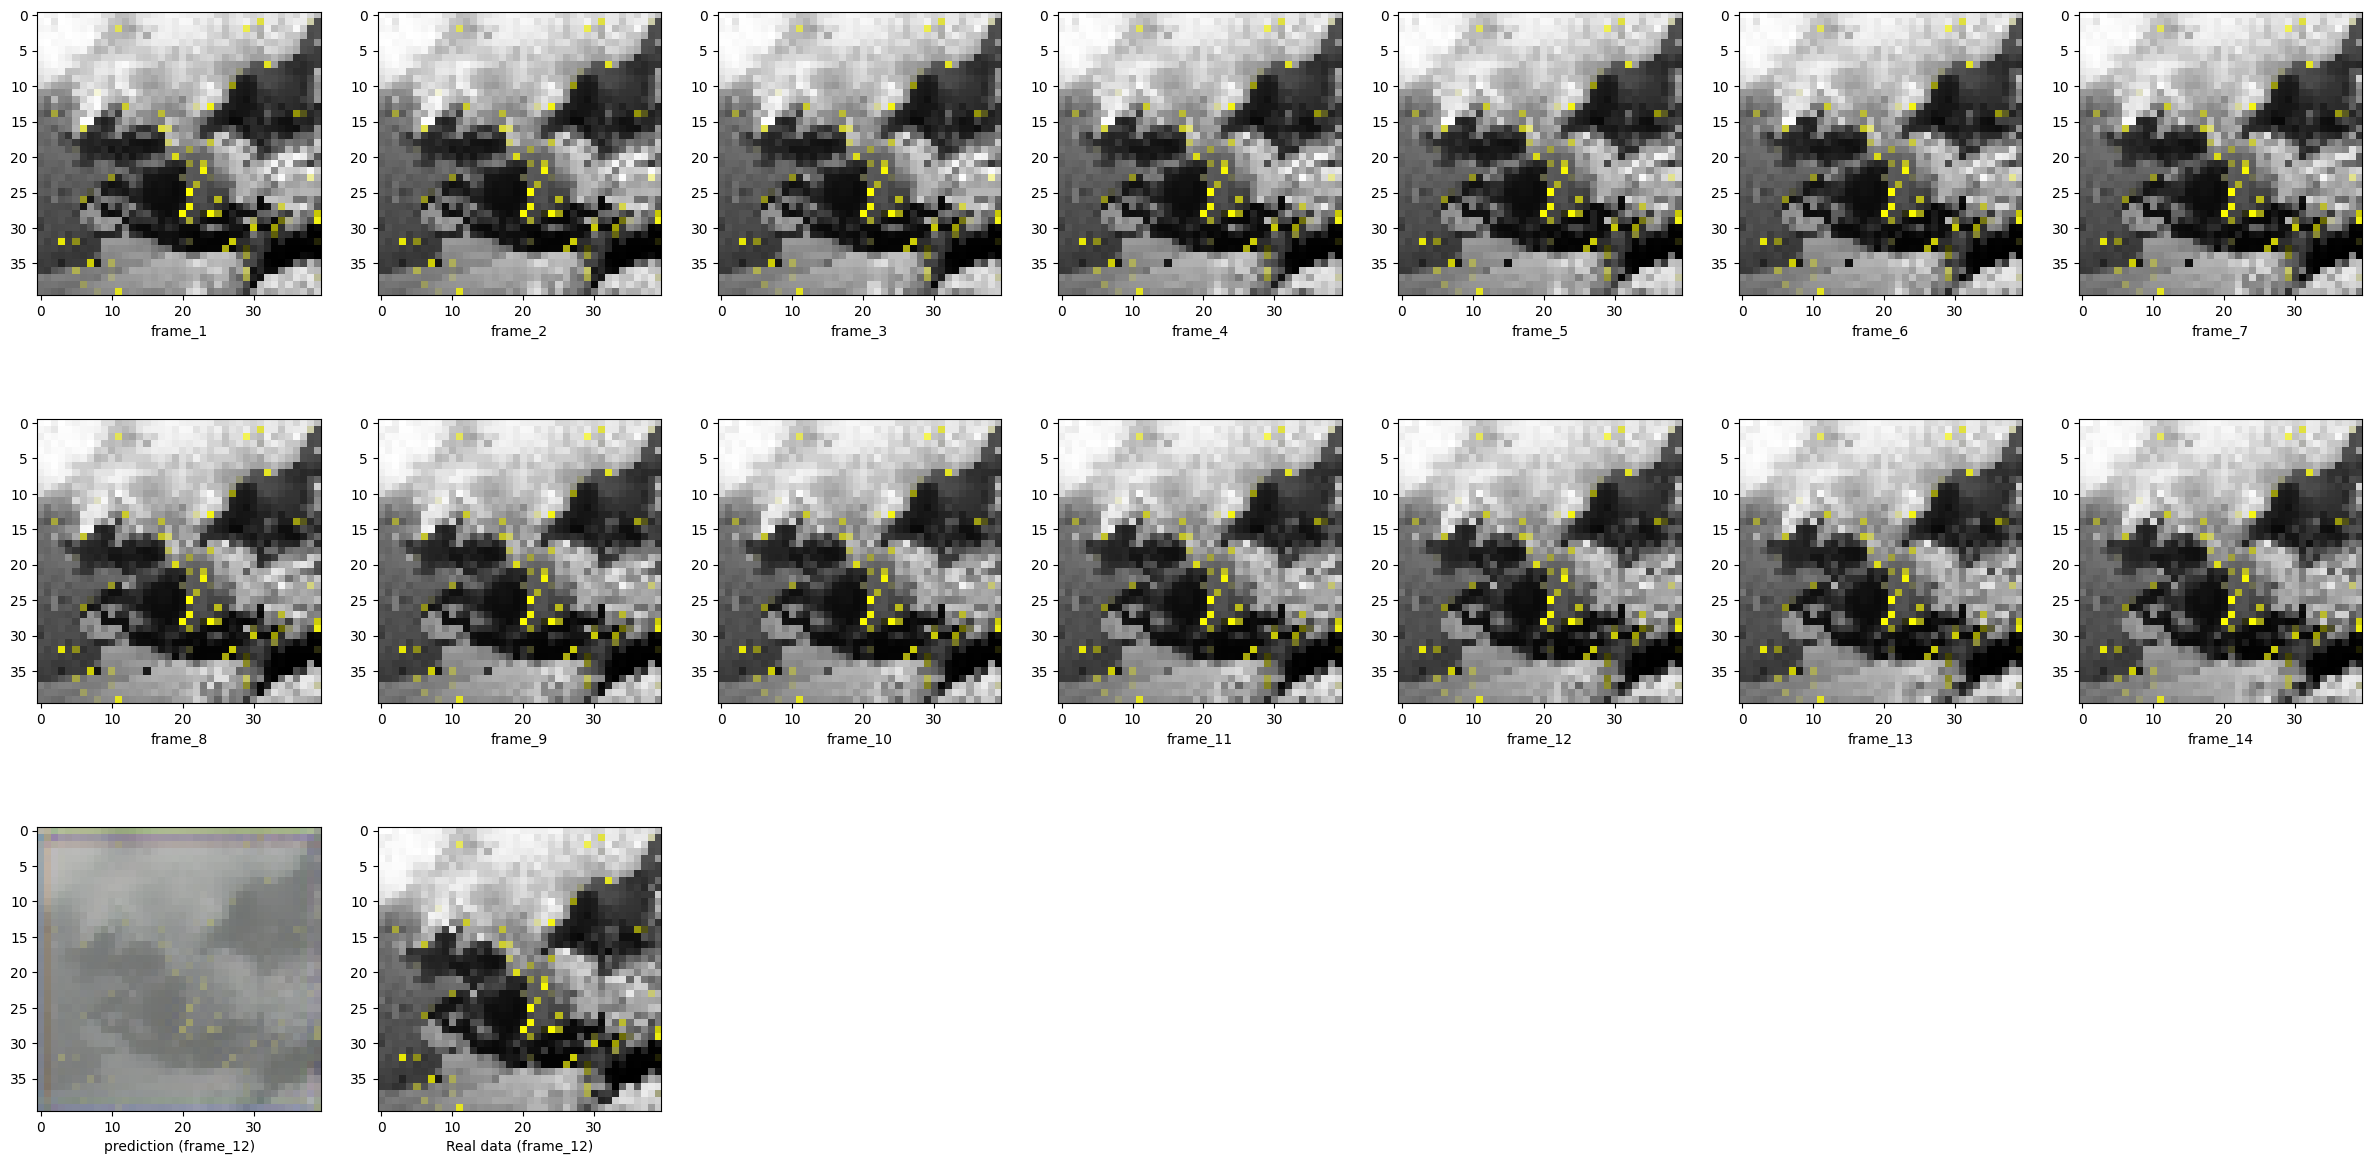

In [178]:
show_result(350)

In [76]:
test_data[0].reshape(1,14,40,40,4)[:,1:,:,:,:].shape

(1, 13, 40, 40, 4)

In [ ]:
def predict_frame(count_frames, test_data, return_data = np.zeros((0,1,40,40,4))):
    print(count_frames,test_data.shape)
    predicted = loded_model.predict(test_data)
    return_data = np.concatenate((return_data,predicted),axis=0)
    if(count_frames == 1):
        return return_data
    new_test_data = np.concatenate((test_data[:,1:,:,:,:],predicted),axis=1)
    print(new_test_data.shape)
    return predict_frame(count_frames-1, new_test_data, return_data)

new_predict = predict_frame(10, test_data[103].reshape(1,14,40,40,4))
new_predict = new_predict.astype("float32")

10 (1, 14, 40, 40, 4)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step
(1, 14, 40, 40, 4)
9 (1, 14, 40, 40, 4)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step
(1, 14, 40, 40, 4)
8 (1, 14, 40, 40, 4)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
(1, 14, 40, 40, 4)
7 (1, 14, 40, 40, 4)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
(1, 14, 40, 40, 4)
6 (1, 14, 40, 40, 4)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step
(1, 14, 40, 40, 4)
5 (1, 14, 40, 40, 4)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
(1, 14, 40, 40, 4)
4 (1, 14, 40, 40, 4)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
(1, 14, 40, 40, 4)
3 (1, 14, 40, 40, 4)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step
(1, 14, 40, 40, 4)
2 (1, 14, 40, 40, 4)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
(1, 14, 40, 40, 4)
1 (1, 14, 40, 40, 4)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


In [94]:
new_predict.shape

(10, 1, 40, 40, 4)

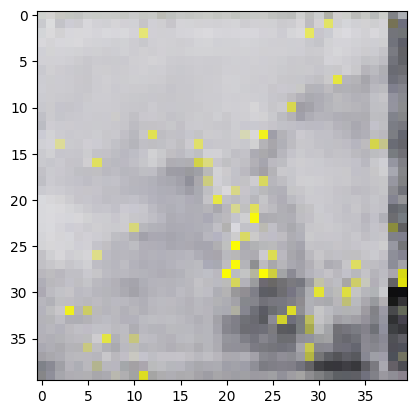

In [104]:
plt.imshow(new_predict[9,0,:,:,:])